Exercise 1: Train a classifier to predict the output labels of the given images. The training and validation images with their labels are given as numpy arrays (one row per image) in 5 chunks (see below). The test images (no labels) are given in a test.csv file (also with one row per image). The images are of size (32,32,3). 

- Write a Dataset class and use it for the dataloaders
- Build and train an appropriate NN
- Plot loss values during training and compute model accuracy

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchsummary import summary
import pandas as pd
from torch.utils.data import Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import pandas as pd

## Data uploading

In [2]:
!wget -O data.zip https://www.dropbox.com/s/bcrs90kyytjph42/cifar-10-batches-py.zip?dl=0
!unzip data.zip

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')
    return dict_

# data is given in 5 chunks, read into numpy arrays
dict1=unpickle("/content/cifar-10-batches-py/data_batch_1")
dict2=unpickle("/content/cifar-10-batches-py/data_batch_2")
dict3=unpickle("/content/cifar-10-batches-py/data_batch_3")
dict4=unpickle("/content/cifar-10-batches-py/data_batch_4")
dict5=unpickle("/content/cifar-10-batches-py/data_batch_5")

images1, labels1 = dict1[b"data"] , dict1[b"labels"]
images2, labels2 = dict2[b"data"] , dict2[b"labels"]
images3, labels3 = dict3[b"data"] , dict3[b"labels"]
images4, labels4 = dict4[b"data"] , dict4[b"labels"]
images5, labels5 = dict5[b"data"] , dict5[b"labels"]

--2023-01-16 10:25:44--  https://www.dropbox.com/s/bcrs90kyytjph42/cifar-10-batches-py.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/bcrs90kyytjph42/cifar-10-batches-py.zip [following]
--2023-01-16 10:25:45--  https://www.dropbox.com/s/raw/bcrs90kyytjph42/cifar-10-batches-py.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0654292a3d9a78846ae426649e.dl-eu.dropboxusercontent.com/cd/0/inline/B0pElQ2o2t_Z_sTzeDZVnvGjuzkaUPNC7-A39QPwlOuj-A8LWRwYdps2_SAG80efI4lQaMzA1hOfd8I8__lyod2Bo8nuV413VrcneIACxWzWV1UZGspsaX6I0MHor336kJeraCmdQPBgc42CpweU8ffau02f07pi1MN62Kn2ZG2GYw/file# [following]
--2023-01-16 10:25:45--  https://uc0654292a3d9a78846ae426649e.dl-eu.dropboxusercontent.com/cd/0/inline/B0pElQ2o2t_Z_sTzeDZVnvGjuzkaUPNC7-A3

## Dataset class and dataloaders
##### - Create a dataset class and use it to construct dataloaders for training and validation.
##### - Use one chunck of the data for validation and the rest for training. 
##### - Note: Concatenating numpy arrays can be done via np.concatenate()


In [3]:
class DATA(Dataset):

    def __init__(self, images, labels):
        super().__init__() 
        self.x=images.astype(np.float32).reshape(-1,3,32,32) / 255.0
        
        self.y=labels

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.x[idx]
        image = torch.tensor(image)
        
        label = torch.tensor(self.y[idx])
        return image, label

In [4]:
trainImages=np.concatenate((images1, images2,  images3, images4), axis=0)
trainLabels=np.concatenate((labels1, labels2,labels3,labels4), axis=0)

trainset = DATA(trainImages, trainLabels)
valImage=images5
valLabels=labels5

batch_size=4

valset=DATA(valImage,valLabels)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Visualize the data
##### Show a few samples of the training dataset


torch.Size([4, 3, 32, 32])


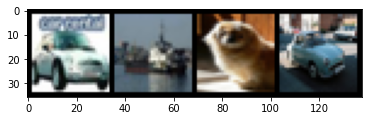

car   ship  dog   car  


In [5]:

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(valloader)
images, labels = next(dataiter)
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Network definition

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop1=nn.Dropout2d(p=0.3)
        self.bn1= nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 5,1,1)
        self.bn2= nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*6*6, 784)
        self.fc2 = nn.Linear(784, 512)
        self.fc3 = nn.Linear(512, 256)
        self.drop2=nn.Dropout(p=0.4)
        self.fc4 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x=self.drop1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 128*6*6)
        x = F.relu(self.fc1(x))
        x=self.drop2(x)
        x = F.relu(self.fc2(x))
        x=self.drop2(x)
        x = F.relu(self.fc3(x))
        x=self.drop2(x)
        x = self.fc4(x)
        return x
net=Net()
net.to(device)
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 29, 29]           3,136
       BatchNorm2d-2           [-1, 64, 29, 29]             128
         MaxPool2d-3           [-1, 64, 14, 14]               0
         Dropout2d-4           [-1, 64, 14, 14]               0
            Conv2d-5          [-1, 128, 12, 12]         204,928
       BatchNorm2d-6          [-1, 128, 12, 12]             256
         MaxPool2d-7            [-1, 128, 6, 6]               0
            Linear-8                  [-1, 784]       3,613,456
           Dropout-9                  [-1, 784]               0
           Linear-10                  [-1, 512]         401,920
          Dropout-11                  [-1, 512]               0
           Linear-12                  [-1, 256]         131,328
          Dropout-13                  [-1, 256]               0
           Linear-14                   

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

## Training
##### Plot loss values during training

[1,  2000] loss: 1.498
[1,  4000] loss: 1.453
[1,  6000] loss: 1.383
[1,  8000] loss: 1.369
[1, 10000] loss: 1.375
Accuracy of the network validation images: 58 %
[2,  2000] loss: 1.311
[2,  4000] loss: 1.288
[2,  6000] loss: 1.251
[2,  8000] loss: 1.259
[2, 10000] loss: 1.249
Accuracy of the network validation images: 62 %
[3,  2000] loss: 1.185
[3,  4000] loss: 1.198
[3,  6000] loss: 1.187
[3,  8000] loss: 1.166
[3, 10000] loss: 1.164
Accuracy of the network validation images: 65 %
[4,  2000] loss: 1.091
[4,  4000] loss: 1.112
[4,  6000] loss: 1.111
[4,  8000] loss: 1.113
[4, 10000] loss: 1.105
Accuracy of the network validation images: 68 %
[5,  2000] loss: 1.040
[5,  4000] loss: 1.067
[5,  6000] loss: 1.031
[5,  8000] loss: 1.035
[5, 10000] loss: 1.053
Accuracy of the network validation images: 69 %
[6,  2000] loss: 1.003
[6,  4000] loss: 0.990
[6,  6000] loss: 0.987
[6,  8000] loss: 0.996
[6, 10000] loss: 1.010
Accuracy of the network validation images: 70 %
[7,  2000] loss: 0.945

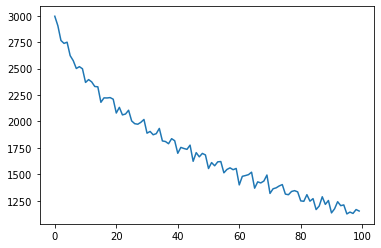

In [40]:
ls=[]
for epoch in range(20):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels=inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        ls.append(running_loss)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            
            running_loss = 0.0
    correct = 0
    total = 0
    # since we're not training, no need to calculate gradients
    net.eval()
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels=images.to(device), labels.to(device)
            # run images through the network
            outputs = net(images)
            # the class with highest val is the prediction
            predicted = torch.argmax(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network validation images: {100 * correct // total} %')
    
  

plt.plot(ls)
print('Finished Training')


## Validation
##### Compute model accuracy



In [42]:
correct = 0
total = 0
# since we're not training, no need to calculate gradients
net.eval()
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images, labels=images.to(device), labels.to(device)
        # run images through the network
        outputs = net(images)
        # the class with highest val is the prediction
        predicted = torch.argmax(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network validation images: {100 * correct / total} %')

Accuracy of the network validation images: 76.58 %


## Testing
##### Read the test.csv file into a numpy array, and then generate predictions
##### Save the predictions to a file that you will email with your code

In [38]:
class Test(Dataset):

    def __init__(self, imagesfile):
        super().__init__()
        df_x = pd.read_csv(imagesfile, header=None)       
        self.X=df_x.iloc[:, :].to_numpy().astype(np.float32).reshape(-1,3,32,32) / 255.0

    def __len__(self):
        return 0
    def __getitem__(self, idx):
        image = self.X[idx]
        image = torch.tensor(image)
        return image

In [125]:
from torch.types import Device
from numpy import savetxt
testset=Test('/content/cifar-10-batches-py/test.csv')
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                            shuffle=False)
device = 'cpu'
net.to(device)
predictionl=np.array(0)
net.eval()
with torch.no_grad():
    for data in testloader:
        images = data
        images=images.to(device)
        # run images through the network
        outputs = net(images)
        # the class with highest test is the prediction
        predicted = torch.argmax(outputs.data, 1)
        predicted = predicted.numpy()
        predictionl = np.append(predictionl, predicted)
predictionl.shape
#savetxt("predictionl.csv", predictionl, delimiter=",")

()

In [126]:
predicted

tensor([6, 0, 1, 8], device='cuda:0')

In [129]:
# save the model
PATH = '\myNet.pth'
torch.save(net.state_dict(), PATH)
# the below lines will load the model
# net = Net()
# net.load_state_dict(torch.load(PATH))